In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy

from abc import ABC, abstractmethod
from fractions import Fraction
from matplotlib.colors import LogNorm
from scipy.integrate import solve_ivp
from scipy import fftpack
from sklearn.metrics import mean_squared_error

In [98]:
class EpidemiologyModel(ABC):
    def __init__(self, initial_conditions, parameters, t, steps=None, plot_size=(20, 6), save_img=False):
        self.initial_conditions = initial_conditions
        self.parameters = parameters
        self.t = t
        self.title = 'Epidemiology Model'
        self.plot_size = plot_size
        
        if steps is None:
            self.t_eval = np.arange(0, t)
        else:
            self.t_eval = np.linspace(0, t, steps)

    def solve(self, equations):
        sol = solve_ivp(
            equations,
            [0, self.t],
            y0=list(self.initial_conditions.values()),
            args=self.parameters,
            t_eval=self.t_eval,
            dense_output=True
        )        
        return sol.sol(self.t_eval)
    
    def time_plot(self, data, labels, axis_labels):
        width, height = self.plot_size
        fig, ax = plt.subplots(figsize=(width, height))

        t_span = np.arange(0, self.t)

        for label, values in zip(labels, data):
            ax.plot(t_span, values, label=label)

        x_label, y_label = axis_labels
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend()
        ax.grid()

        return fig, ax
    
    def phase_plot(self, lines=11, turn_off_initial_points=False, turn_off_end_points=True, show_equilibrium=False):
        width, height = self.plot_size
        fig, ax = plt.subplots(figsize=(width, height))
        copy_conditions = copy.deepcopy(self.initial_conditions)

        init_condition_S = []
        end_condition_S = []
        init_condition_I = []
        end_condition_I = []
        
        for init_I in np.linspace(0, 1, lines):
            self.initial_conditions["I"] = init_I
            self.initial_conditions["S"] = 1 - init_I
            sol_phase = self.solve(self.equations)

            ax.plot(sol_phase[0], sol_phase[1])
            init_condition_S.append(sol_phase[0][0])
            end_condition_S.append(sol_phase[0][-1])
            init_condition_I.append(sol_phase[1][0])
            end_condition_I.append(sol_phase[1][-1])

        
        if not turn_off_initial_points:
            ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
        if not turn_off_end_points:
            ax.plot(end_condition_S, end_condition_I, 'k--', color='black', marker='o')
        if show_equilibrium:
            equilibrium_S = np.mean(end_condition_S[1:])
            equilibrium_I = np.mean(end_condition_I[1:])
            ax.plot(equilibrium_S, equilibrium_I, 'ro', markersize=8, label='Equilibrium')
        ax.set_xlabel("Susceptible (S)")
        ax.set_ylabel("Infected (I)")
        ax.legend()
        ax.grid()

        self.initial_conditions = copy_conditions
        return fig, ax
    
    def fourier_plot(self, data, label, colour, x_max=0.4):
        width, height = self.plot_size
        fig, ax = plt.subplots(figsize=(width, height))

        fourier = fftpack.fft(data)
        freqs = fftpack.fftfreq(len(data))

        freqs, fourier = zip(*sorted(zip(freqs, fourier)))
        i_min = freqs.index(0)
        i_max = freqs.index(max(freqs))

        ax.plot(freqs[i_min:i_max], np.abs(np.real(fourier))[i_min:i_max], label=f'{label}', color=colour)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid()

        return fig, ax


    def set_params(self, params):
        self.parameters = params
    
    def set_conditions(self, conditions):
        self.initial_conditions = conditions

    @abstractmethod
    def equations(self, t, init_y):
        pass

    @abstractmethod
    def R0(self):
        pass

--------------
# Problem 1: Numerical integration of the SIR model

In [3]:
class SIR(EpidemiologyModel):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        super().__init__(initial_conditions, parameters, t, steps)

    def equations(self, t, init_y, beta, gamma):
        S, I, R = init_y
        dSdt = -beta * S * I
        dIdt = beta * S * I - gamma * I
        dRdt = gamma * I
        return [dSdt, dIdt, dRdt]

    def R0(self):
        beta, gamma = self.parameters
        return round(beta / gamma, 2) if gamma != 0 else 0

$$
\begin{align}
\frac{dS}{dt} &= -\beta S I, \\
\frac{dI}{dt} &= \beta S I - \gamma I, \\
\frac{dR}{dt} &= \gamma I,
\end{align}
$$

## 1.1. Numerically integrate the ODEs to show two scenarios

/tmp/ipykernel_8702/3389657654.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/1843057157.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/3389657654.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


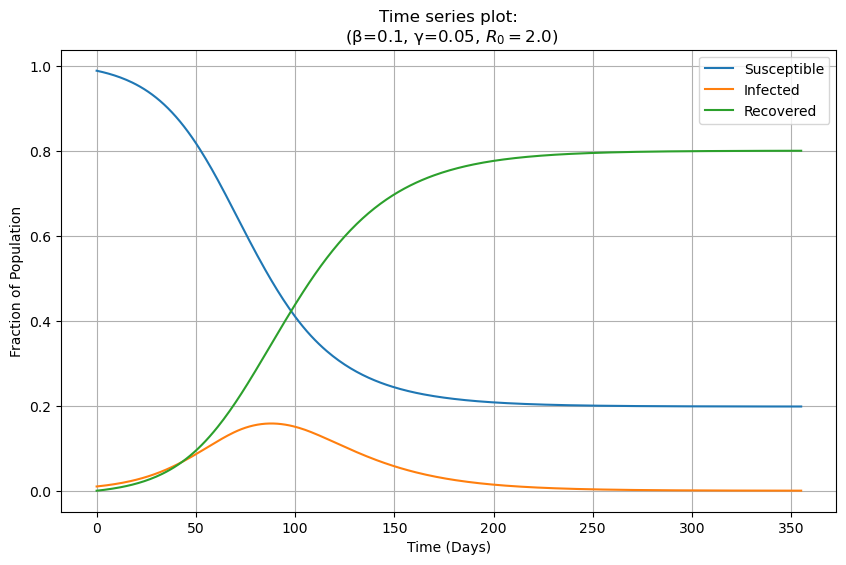

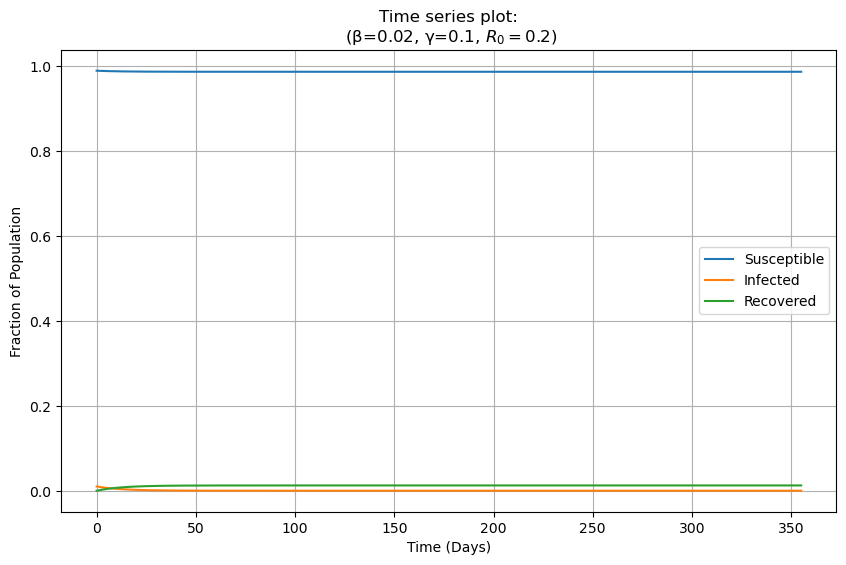

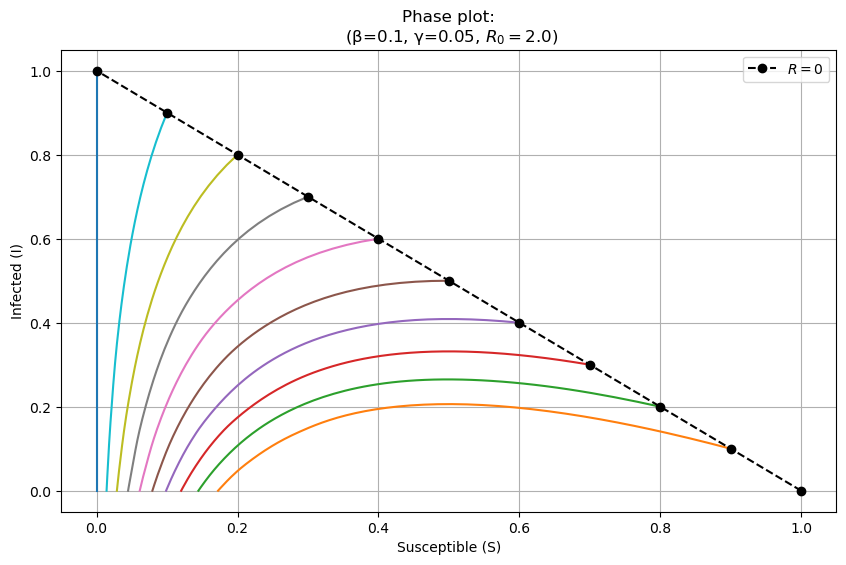

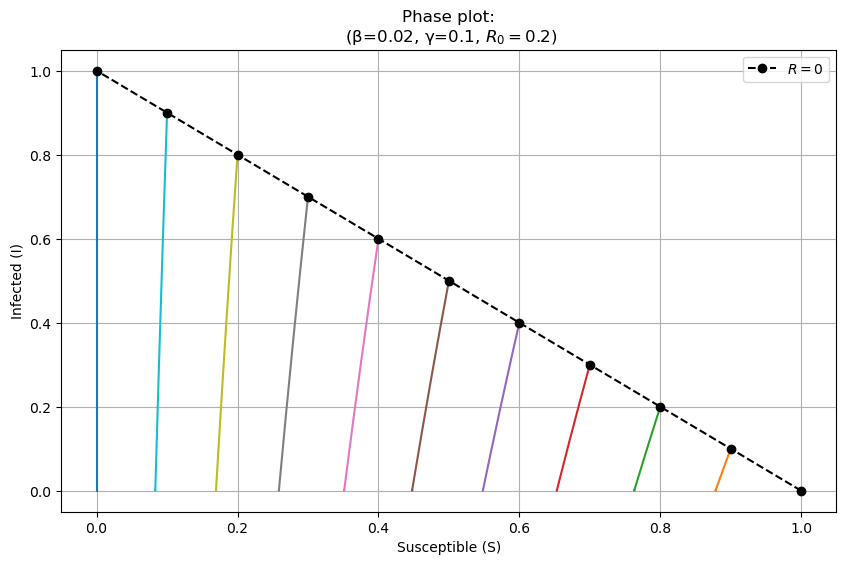

In [4]:
scenarios = {"epidemic":(0.1, 0.05), "no epidemic":(0.02, 0.1)}
y0 = {"S": 0.99, "I": 0.01, "R": 0}
t = 356

for parameters in scenarios.values():
    sir_model = SIR(y0, parameters, t)
    sir_data = sir_model.solve(sir_model.equations)

    fig, ax = sir_model.time_plot(sir_data, ["Susceptible", "Infected", "Recovered"], ["Time (Days)", "Fraction of Population"])
    R0 = sir_model.R0()
    ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, $R_0={R0}$)")
    fig.show()

for parameters in scenarios.values():
    sir_model = SIR(y0, parameters, t)
    sir_data = sir_model.solve(sir_model.equations)

    fig, ax = sir_model.phase_plot(turn_off_end_points=True)
    R0 = sir_model.R0()
    ax.set_title(f"Phase plot:\n (β={parameters[0]}, γ={parameters[1]}, $R_0={R0}$)")
    fig.show()

The effect of different beta and gamma values on the $R_0$.
When $R_0 < 1 $ no epidemic can occur.

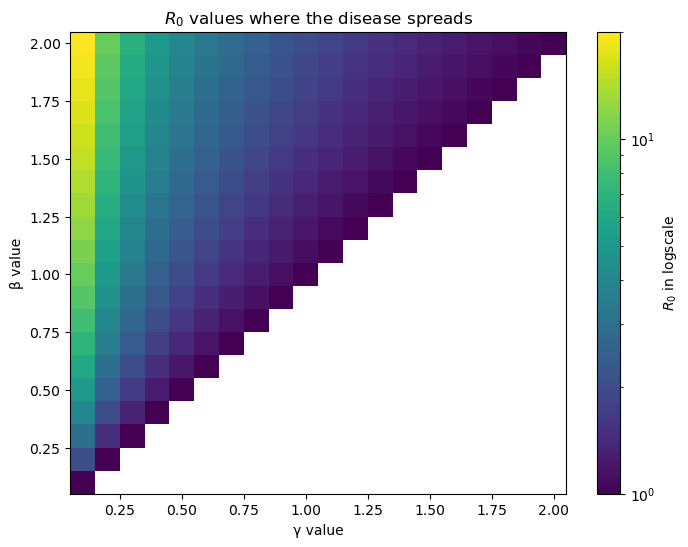

In [5]:
MAX_BETA = 2.1
MAX_GAMMA = 2.1
STEP_SIZE = 0.1

beta_values = np.arange(0.1, MAX_BETA, STEP_SIZE)
gamma_values = np.arange(0.1, MAX_GAMMA, STEP_SIZE)

R0_values = np.zeros((len(beta_values), len(gamma_values)))

for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        R0_values[i, j] = beta / gamma

masked_R0_values = np.ma.masked_where(R0_values < 1, R0_values)

fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(gamma_values, beta_values, masked_R0_values, shading='auto', cmap='viridis', norm=LogNorm(vmin=masked_R0_values.min(), vmax=masked_R0_values.max()))
ax.set_xlabel('γ value')
ax.set_ylabel('β value')
ax.set_title('$R_0$ values where the disease spreads')
fig.colorbar(c, ax=ax, label='$R_0$ in logscale')

plt.show()

## 1.2. Fit the parameters based on historical influenza outbreak within a boys school

In [6]:
target = np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])
df = pd.DataFrame({
    'Number': target
})
print("Target:")
df.T

Target:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Number,1,3,8,28,75,221,291,255,235,190,125,70,28,12,5


In [7]:
N = 763
init_infected = 1
I0 = init_infected / N
R0 = 0.0
S0 = 1 - (I0 + R0)

y0 = {"S": S0, "I": I0, "R": R0}
t = 15

In [8]:
STEP_SIZE = 0.01
INFECTED = 1

beta_range = np.arange(0, MAX_BETA, STEP_SIZE)
gamma_range = np.arange(0, MAX_GAMMA, STEP_SIZE)

best_beta, best_gamma = 0.0, 0.0
lowest_error = float('inf')
error_matrix = np.zeros((len(beta_range), len(gamma_range)))
sir_model = SIR(y0, (best_beta, best_gamma), t)

for i, beta in enumerate(beta_range):
    for j, gamma in enumerate(gamma_range):
        sir_model.set_params((beta, gamma))
        I_data = sir_model.solve(sir_model.equations)[INFECTED]

        error = mean_squared_error(I_data * N, target)
        error_matrix[i][j] = error
        if error < lowest_error:
            lowest_error = error
            best_beta, best_gamma = beta, gamma

print(f"Best parameters: β = {best_beta:.2f}, γ = {best_gamma:.2f}")
print(f"Lowest error: {lowest_error:.2f}")

Best parameters: β = 1.67, γ = 0.45
Lowest error: 269.98


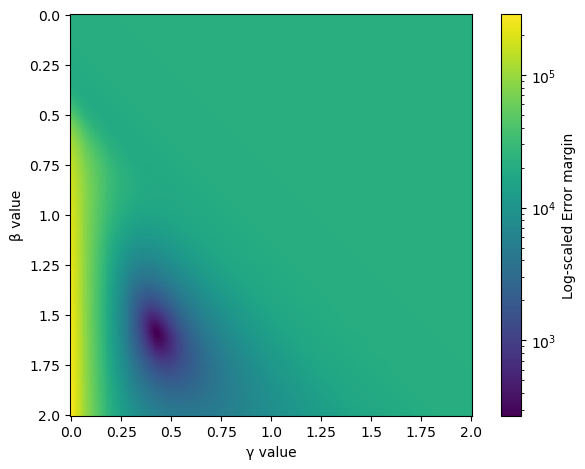

In [9]:
AXIS_POINTS = 9
plt.imshow(error_matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest')

x_ticks = np.linspace(0, error_matrix.shape[1]-1, AXIS_POINTS)
y_ticks = np.linspace(0, error_matrix.shape[0]-1, AXIS_POINTS)
plt.xticks(x_ticks, np.round(np.linspace(0, MAX_BETA - 0.1, AXIS_POINTS), 2)) 
plt.yticks(y_ticks, np.round(np.linspace(0, MAX_GAMMA - 0.1, AXIS_POINTS), 2)) 

plt.colorbar(label='Log-scaled Error margin')
plt.xlabel('γ value')
plt.ylabel('β value')
plt.tight_layout()
plt.show()

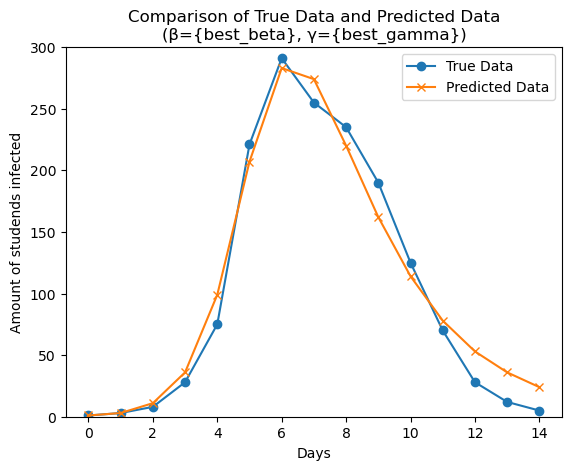

In [10]:
sir_model = SIR(y0, (best_beta, best_gamma), t)
I_data = sir_model.solve(sir_model.equations)[INFECTED]
I_data = np.round(I_data * N, 0).astype(int)

y_min = 0
y_max = 300

x = columns=np.arange(0, t + 1)
plt.plot(np.arange(0, t), target, marker='o', label='True Data')
plt.plot(np.arange(0, t), I_data, marker='x', label='Predicted Data')
plt.xlabel('Days')
plt.ylabel('Amount of studends infected')
plt.title('Comparison of True Data and Predicted Data\n(β={best_beta}, γ={best_gamma})')
plt.ylim(y_min, y_max)
plt.legend()

/tmp/ipykernel_8702/1463231575.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


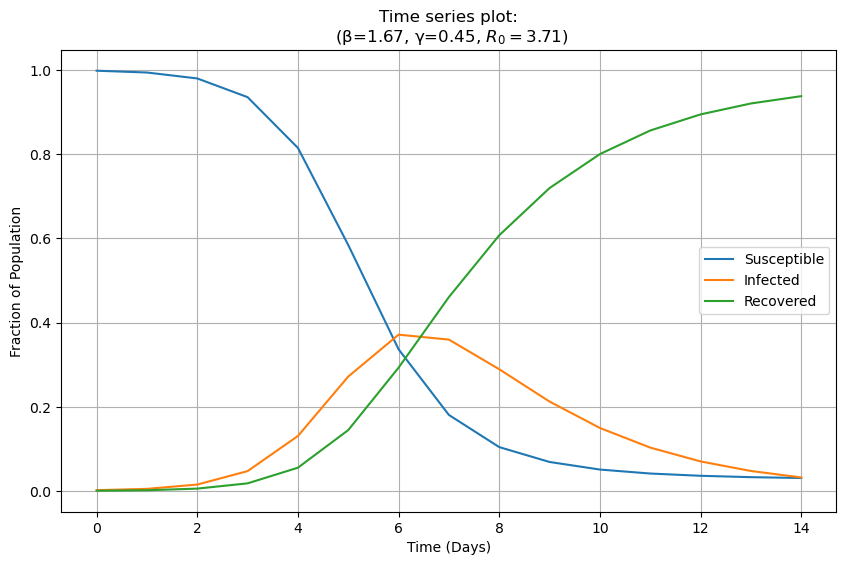

In [11]:
parameters = (best_beta, best_gamma)
sir_model = SIR(y0, parameters, t)
sir_data = sir_model.solve(sir_model.equations)

fig, ax = sir_model.time_plot(sir_data, ["Susceptible", "Infected", "Recovered"], ["Time (Days)", "Fraction of Population"])
R0 = sir_model.R0()
ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, $R_0={R0}$)")
fig.show()

In [12]:
target = np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])
df = pd.DataFrame({
    'Target Number': target,
    'Predicted Number': I_data,
    'MSE difference': [mean_squared_error([value_1], [value_2]) for value_1, value_2 in zip(target, I_data)]
})
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Target Number,1.0,3.0,8.0,28.0,75.0,221.0,291.0,255.0,235.0,190.0,125.0,70.0,28.0,12.0,5.0
Predicted Number,1.0,3.0,11.0,36.0,99.0,207.0,283.0,274.0,220.0,162.0,114.0,78.0,53.0,36.0,24.0
MSE difference,0.0,0.0,9.0,64.0,576.0,196.0,64.0,361.0,225.0,784.0,121.0,64.0,625.0,576.0,361.0


# 1.3 Think of possible vaccination strategies for the school case

In [13]:
class SIRV(EpidemiologyModel):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        super().__init__(initial_conditions, parameters, t, steps)

    def equations(self, t, init_y, beta, gamma, v):
        S, I, R, V = init_y
        dSdt = (-beta * S * I) - v * S
        dIdt = (beta * S * I) - gamma * I
        dRdt = gamma * I
        dVdt = v * S
        return [dSdt, dIdt, dRdt, dVdt]

    def R0(self):
        # R_0 based on Turkyilmazoglu (2022).
        beta, gamma, v = self.parameters
        return round(beta + v / gamma, 2) if gamma != 0 else 0

$$
\begin{align}
\frac{dS}{dt} &= -\beta S I - \nu S, \\
\frac{dI}{dt} &= \beta S I - \gamma I, \\
\frac{dR}{dt} &= \gamma I, \\
\frac{dV}{dt} &= \nu S.
\end{align}
$$

In [14]:
def peak_plot(init_model_with, init_model_without, xlabel, title, size=(20, 6), use_vacc_rate=True):
    plt.figure(figsize=size)
    vacc_values = np.arange(0, 1, 0.01)

    model_with = copy.deepcopy(init_model_with)
    model_without = copy.deepcopy(init_model_without)

    peak_values_with = {}
    peak_values_without = np.max(model_without.solve(model_without.equations)[1]) * N
    if use_vacc_rate:
        for v in vacc_values:
            model_with.set_params((parameters[0], parameters[1], v))
            peak_values_with[v] = np.max(model_with.solve(model_with.equations)[1]) * N

    if not use_vacc_rate:
        model_with.set_params((parameters[0], parameters[1], 0))
        for init_V in vacc_values:
            changed_conditions = model_with.initial_conditions.copy()
            changed_conditions["V"] = init_V
            changed_conditions["S"] = 1 - sum(value for key, value in changed_conditions.items() if key != "S")
            model_with.set_conditions(changed_conditions)
            peak_values_with[init_V] = np.max(model_with.solve(model_with.equations)[1]) * N

    values = list(peak_values_with.values())
    keys = list(peak_values_with.keys())
    is_close = np.isclose(values, np.roll(values, shift=1), atol=1)
    asymptote_index = np.argmax(is_close)
    asymptote_v = keys[asymptote_index]

    plt.plot(vacc_values, list(peak_values_with.values()), label='With Vaccination', marker='o')
    plt.axhline(y=peak_values_without, color='orange', linestyle='--', label='Without Vaccination')
    plt.xlabel(xlabel)
    plt.ylabel('Peak Infected')
    plt.ylim(top=300)
    plt.title(title)
    plt.grid()

    return plt, asymptote_v

### Scenario 0: No vaccination

/tmp/ipykernel_8702/1072564811.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/1843057157.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/1072564811.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


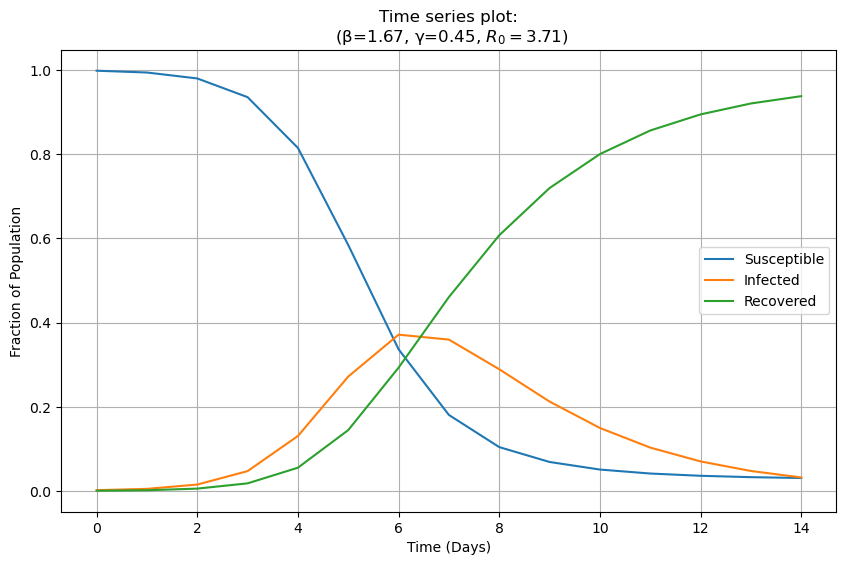

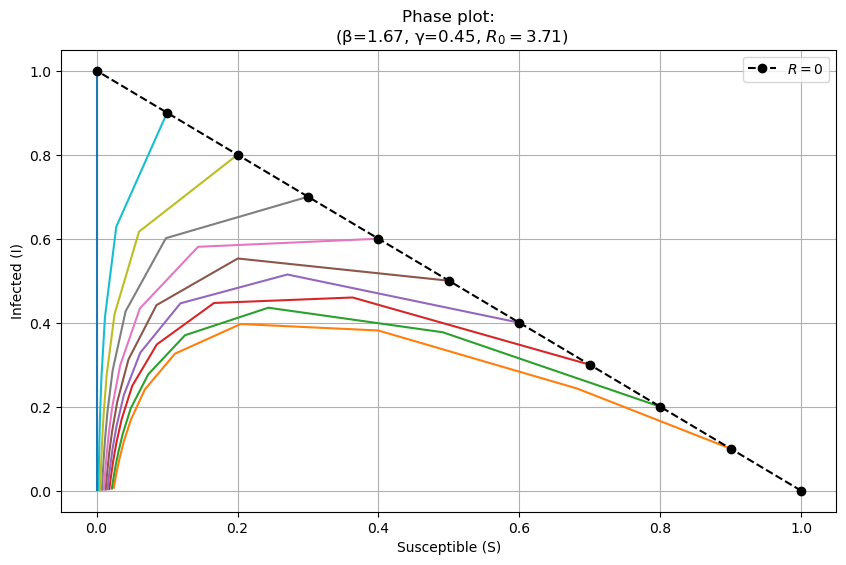

In [15]:
parameters = (best_beta, best_gamma)
sir_model = SIR(y0, parameters, t)
sir_data = sir_model.solve(sir_model.equations)

fig, ax = sir_model.time_plot(sir_data, ["Susceptible", "Infected", "Recovered"], ["Time (Days)", "Fraction of Population"])
R0 = sir_model.R0()
ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, $R_0={R0}$)")
fig.show()

sir_model_copy = copy.deepcopy(sir_model)
fig, ax = sir_model_copy.phase_plot()
ax.set_title(f"Phase plot:\n (β={parameters[0]}, γ={parameters[1]}, $R_0={R0}$)")
fig.show()

### Scenario 1: Vaccinating based on the amount of infected

/tmp/ipykernel_8702/1170581827.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/1843057157.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/1170581827.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


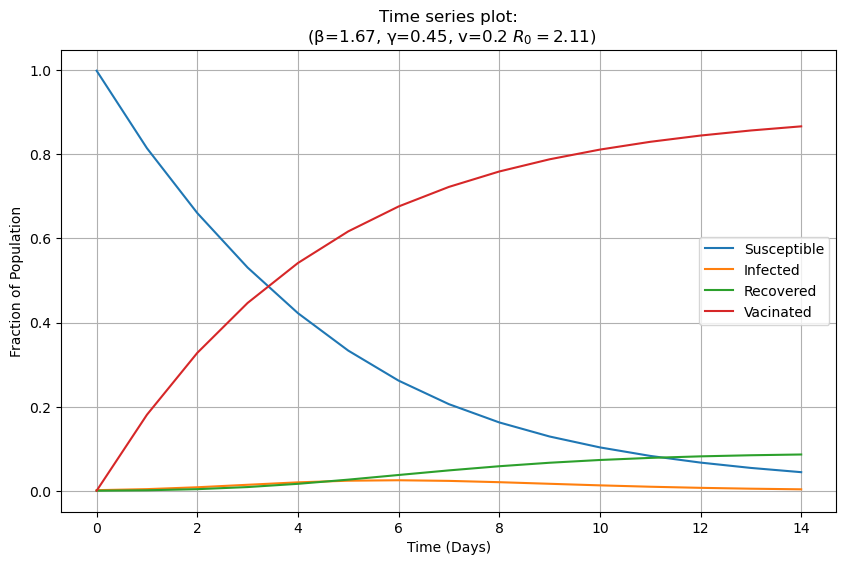

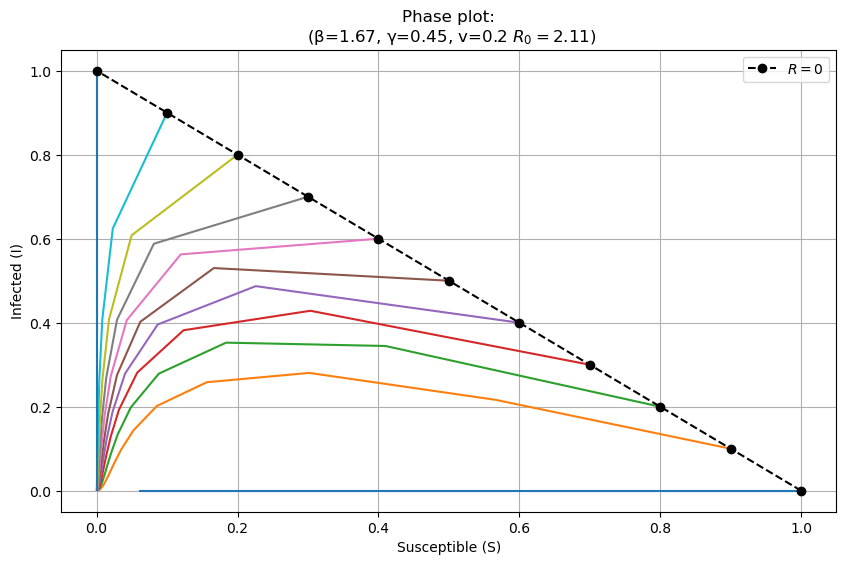

In [16]:
vacc_rate = 0.2
vacc_parameters = parameters + (vacc_rate, )
vacc_y0 = y0.copy()
vacc_y0["V"] = 0.0

sirv_model = SIRV(vacc_y0, vacc_parameters, t)
sirv_data = sirv_model.solve(sirv_model.equations)
R0 = sirv_model.R0()
fig, ax = sirv_model.time_plot(sirv_data, ["Susceptible", "Infected", "Recovered", "Vacinated"], ["Time (Days)", "Fraction of Population"])
ax.set_title(f"Time series plot:\n (β={vacc_parameters[0]}, γ={vacc_parameters[1]}, v={vacc_parameters[2]} $R_0={R0}$)")
fig.show()

sirv_model_copy = copy.deepcopy(sirv_model)
fig, ax = sirv_model.phase_plot()
ax.set_title(f"Phase plot:\n (β={vacc_parameters[0]}, γ={vacc_parameters[1]}, v={vacc_parameters[2]} $R_0={R0}$)")
fig.show()

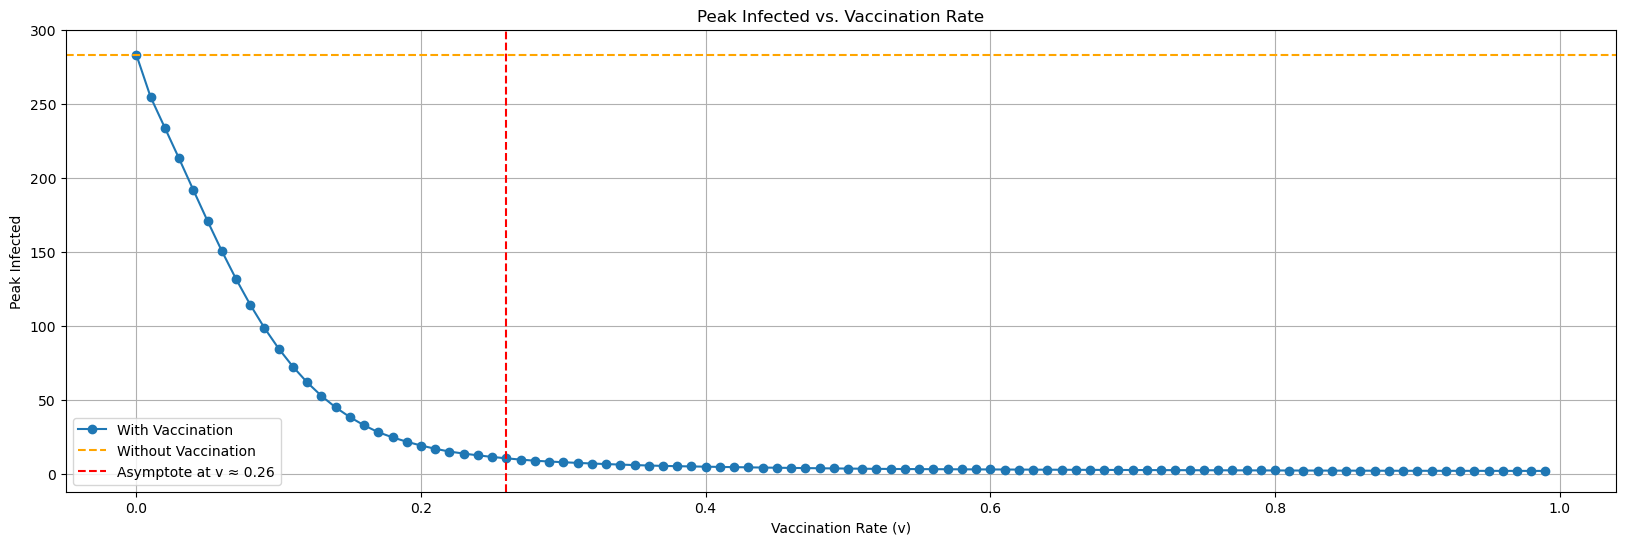

In [17]:
plt, asymptote_v = peak_plot(sirv_model, sir_model, 'Vaccination Rate (v)',
                              'Peak Infected vs. Vaccination Rate')
plt.axvline(x=asymptote_v, color='red', linestyle='--', label=f'Asymptote at v ≈ {asymptote_v:.2f}')
plt.legend()
plt.show()

### Scenario 2: Assuming portion of the population is already vaccinated

/tmp/ipykernel_8702/68611998.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/1843057157.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/68611998.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


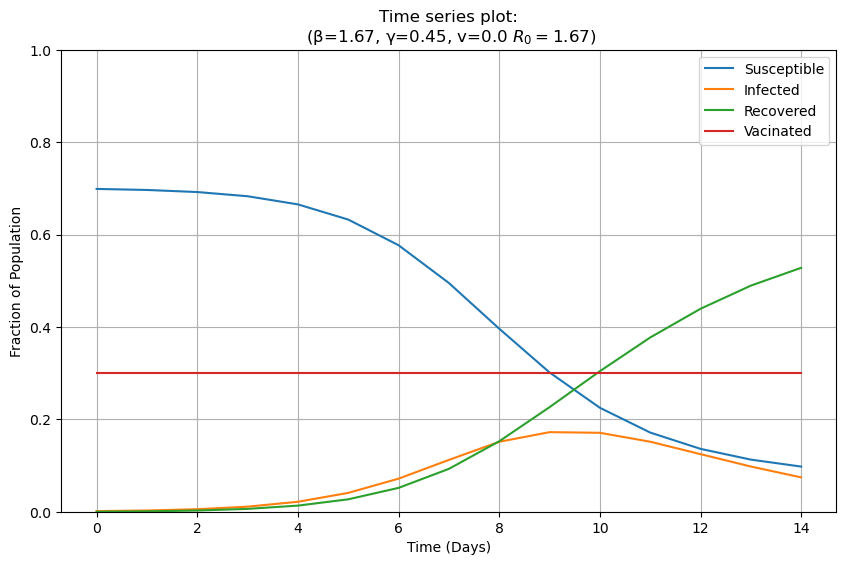

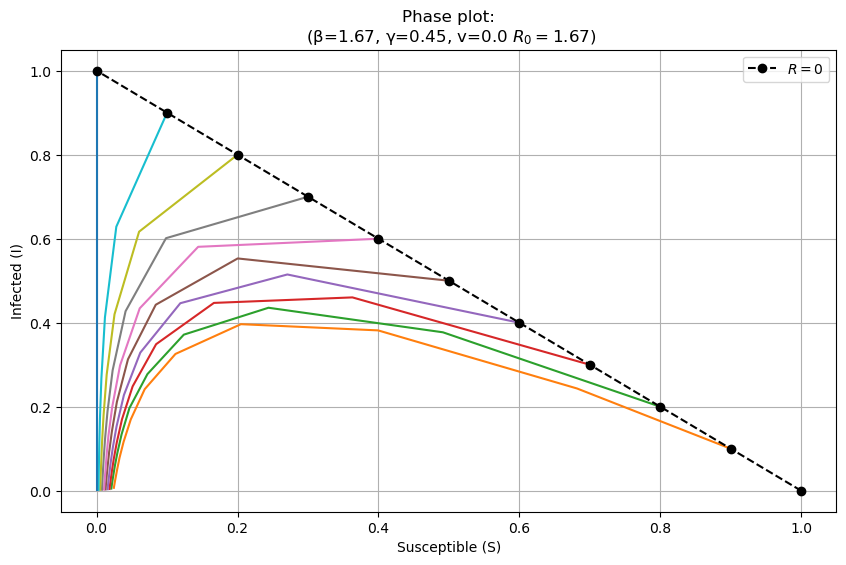

In [25]:
vacc_rate = 0.0
vacc_parameters = parameters + (vacc_rate, )
vacc_y0 = y0.copy()
vacc_y0["V"] = 0.3
vacc_y0["S"] = 1 - (vacc_y0["V"] + vacc_y0["I"] + vacc_y0["R"])

sirv_model = SIRV(vacc_y0, vacc_parameters, t)
sirv_data = sirv_model.solve(sirv_model.equations)
R0 = sirv_model.R0()
fig, ax = sirv_model.time_plot(sirv_data, ["Susceptible", "Infected", "Recovered", "Vacinated"], ["Time (Days)", "Fraction of Population"])
ax.set_title(f"Time series plot:\n (β={vacc_parameters[0]}, γ={vacc_parameters[1]}, v={vacc_parameters[2]} $R_0={R0}$)")
ax.set_ylim(0, 1)
fig.show()

sirv_model_copy = copy.deepcopy(sirv_model)
fig, ax = sirv_model.phase_plot()
ax.set_title(f"Phase plot:\n (β={vacc_parameters[0]}, γ={vacc_parameters[1]}, v={vacc_parameters[2]} $R_0={R0}$)")
fig.show()

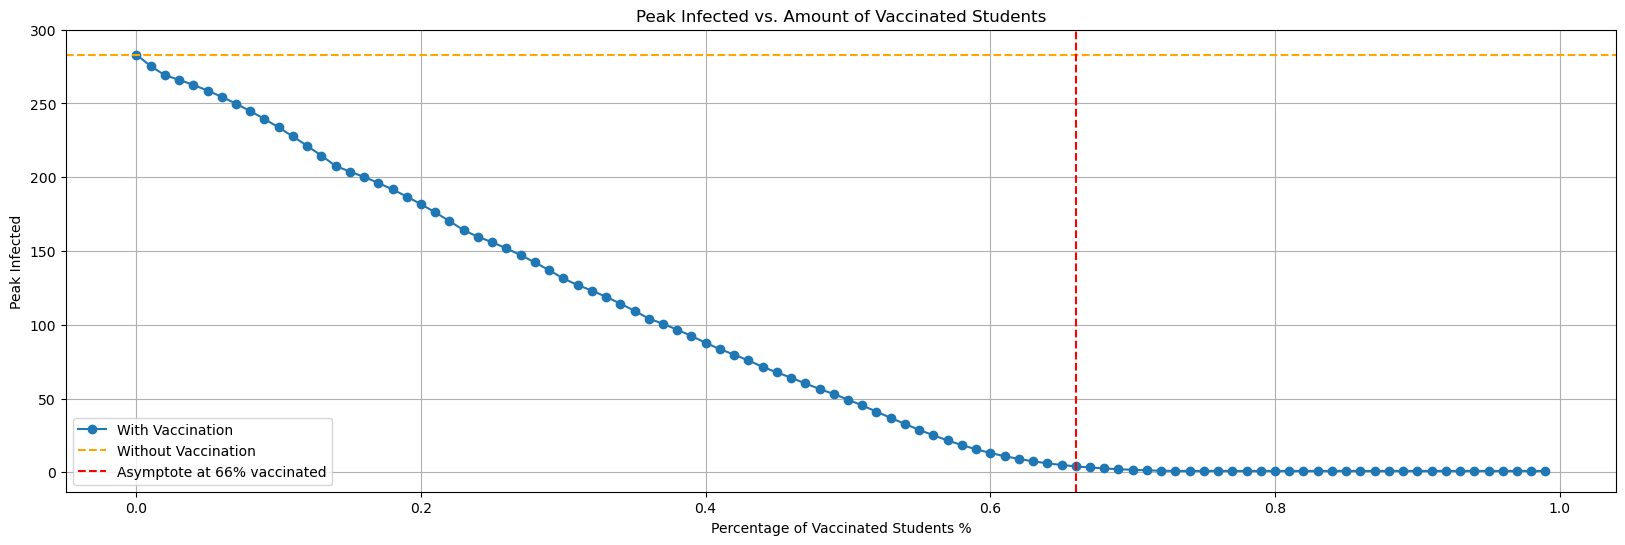

In [26]:
plt, asymptote_v = peak_plot(sirv_model, sir_model, 'Percentage of Vaccinated Students %',
                              'Peak Infected vs. Amount of Vaccinated Students', use_vacc_rate=False)
plt.axvline(x=asymptote_v, color='red', linestyle='--', label=f'Asymptote at {asymptote_v * 100:.0f}% vaccinated')
plt.legend()
plt.show()

--------
# Problem 2: Demography
## 2.1 Natural birth and death rate

In [62]:
class SIR_demographic(EpidemiologyModel):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        super().__init__(initial_conditions, parameters, t, steps)

    def equations(self, t, init_y, beta, gamma, mu):
        S, I, R = init_y
        dSdt = mu - beta * S * I - mu * S
        dIdt = beta * S * I - gamma * I - mu * I
        dRdt = gamma * I - mu * R
        return [dSdt, dIdt, dRdt]

    def R0(self):
        beta, gamma, _ = self.parameters
        return round(beta / gamma, 2) if gamma != 0 else 0

\begin{align}
\frac{dS}{dt} &= \mu -\beta S I - \mu S, \\
\frac{dI}{dt} &= \beta S I - \gamma I - \mu I, \\
\frac{dR}{dt} &= \gamma I - \mu R. \\
\end{align}
Whereby $\mu =$ birth \& deathrate

/tmp/ipykernel_8702/1077403016.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/1835631318.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/1077403016.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


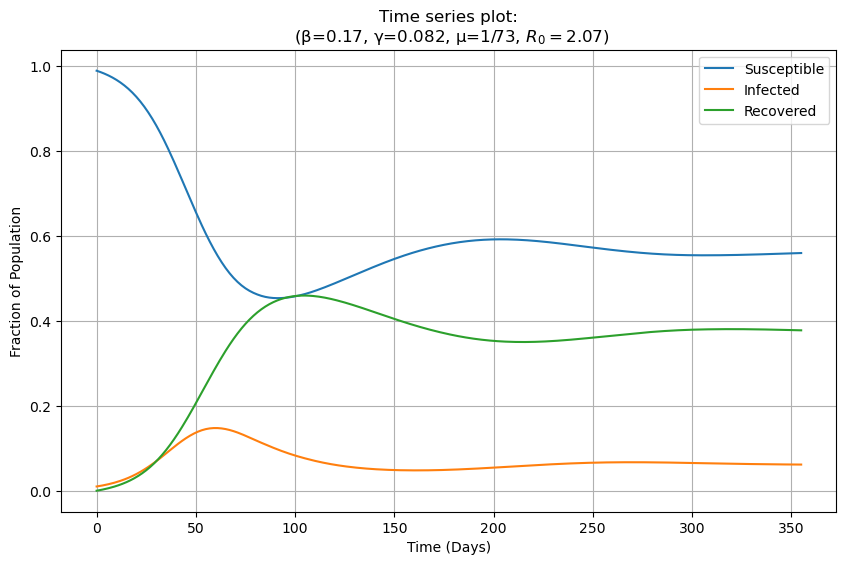

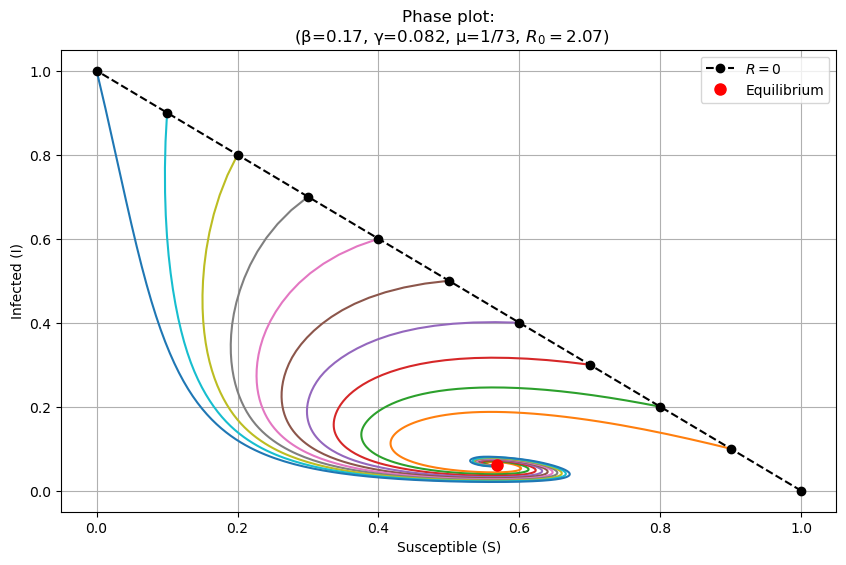

In [63]:
parameters = (0.17, 0.082, Fraction(1, 73))
y0 = {"S": 0.99, "I": 0.01, "R": 0}
t = 356

sir_demographic_model = SIR_demographic(y0, parameters, t)
sir_demographic_data = sir_demographic_model.solve(sir_demographic_model.equations)

fig, ax = sir_demographic_model.time_plot(sir_demographic_data, ["Susceptible", "Infected", "Recovered"], ["Time (Days)", "Fraction of Population"])
R0 = sir_demographic_model.R0()
ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, $R_0={R0}$)")
fig.show()

fig, ax = sir_demographic_model.phase_plot(show_equilibrium=True)
ax.set_title(f"Phase plot:\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, $R_0={R0}$)")
fig.show()

/tmp/ipykernel_8702/293867242.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


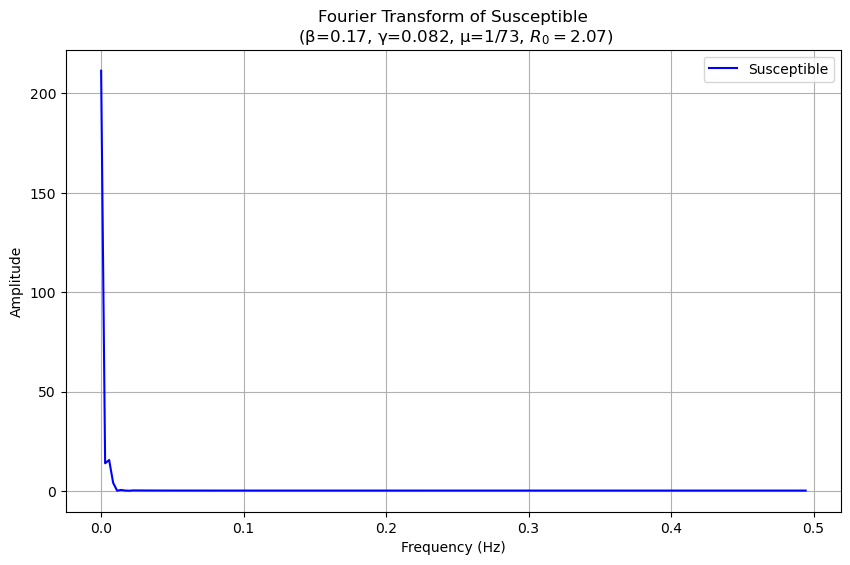

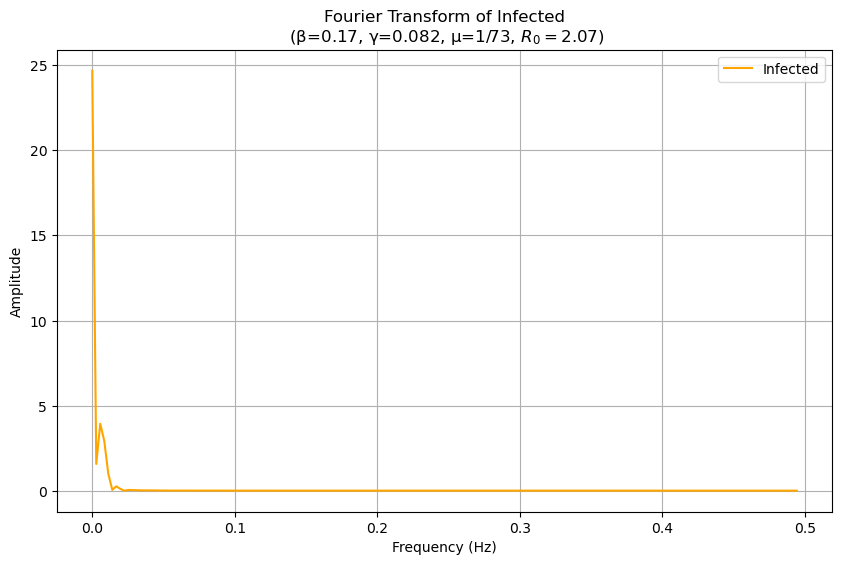

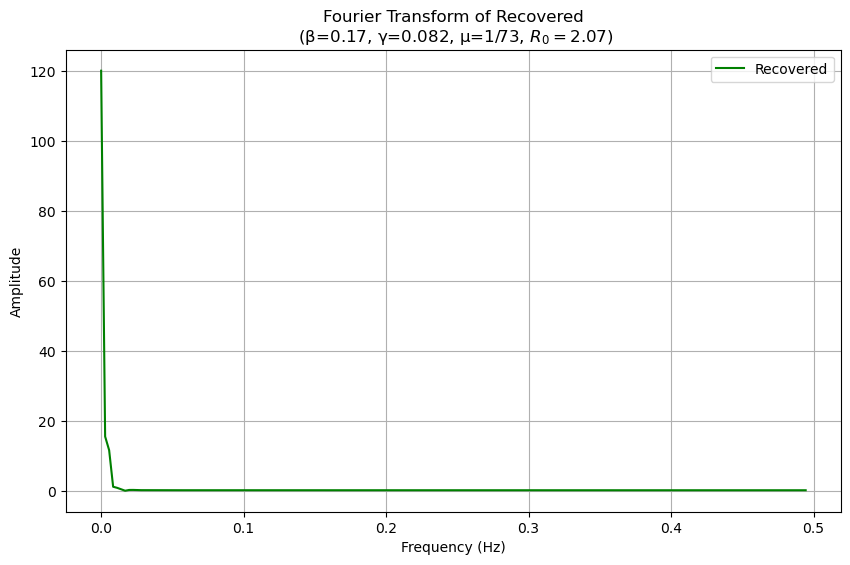

In [64]:
plot_style_dict = {
    "Susceptible": "blue",
    "Infected": "orange",
    "Recovered": "green"
}

for compartment, plot_style in zip(sir_demographic_data, plot_style_dict):
    fig, ax = sir_demographic_model.fourier_plot(compartment, plot_style, plot_style_dict[plot_style])
    R0 = sir_demographic_model.R0()
    ax.set_title(f"Fourier Transform of {plot_style}\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, $R_0={R0}$)")

    fig.show()

## 2.2. Infected mortality

In [65]:
class SIRD_demographic(EpidemiologyModel):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        super().__init__(initial_conditions, parameters, t, steps)

    def equations(self, t, init_y, beta, gamma, mu, delta):
        S, I, R, D = init_y
        dSdt = mu - beta * S * I - mu * S
        dIdt = beta * S * I - gamma * I - mu * I - delta * I
        dRdt = gamma * I - mu * R
        dDdt = delta * I
        return [dSdt, dIdt, dRdt, dDdt]

    def R0(self):
        beta, gamma, _, _ = self.parameters
        return round(beta / gamma, 2) if gamma != 0 else 0

\begin{align}
\frac{dS}{dt} &= \mu -\beta S I - \mu S, \\
\frac{dI}{dt} &= \beta S I - \gamma I - \mu I - \delta I, \\
\frac{dR}{dt} &= \gamma I - \mu R, \\
\frac{dD}{dt} &= \delta I.
\end{align}

Whereby $\mu =$ birth & deathrate and $\delta = $ infected mortality

/tmp/ipykernel_8702/1577250378.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/1835631318.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/1577250378.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


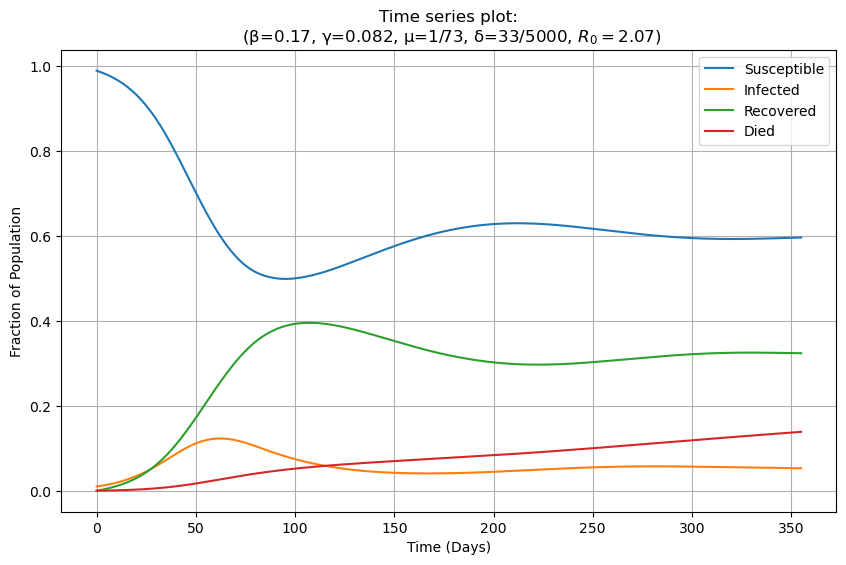

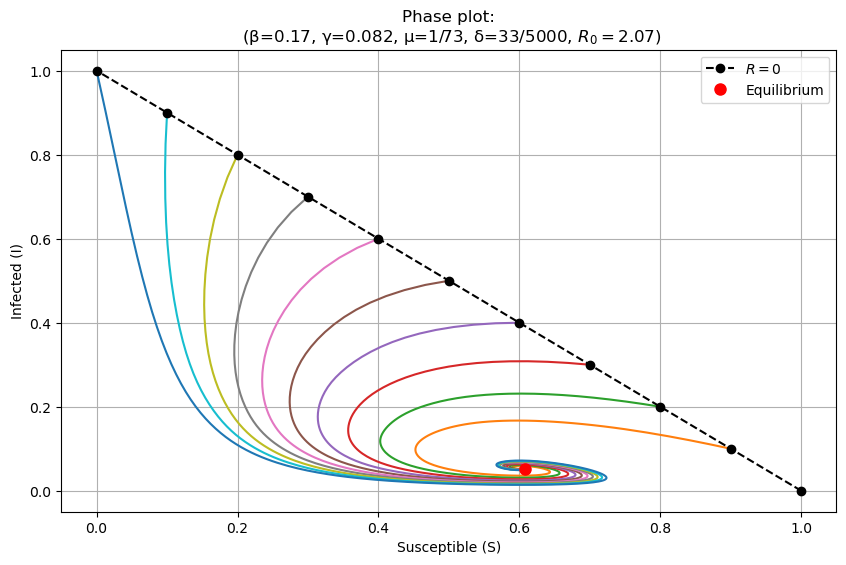

In [66]:
parameters = (0.17, 0.082, Fraction(1, 73), Fraction(33, 5000))
y0 = {"S": 0.99, "I": 0.01, "R": 0, "D": 0}

sird_demographic_model = SIRD_demographic(y0, parameters, t)
sird_demographic_data = sird_demographic_model.solve(sird_demographic_model.equations)

fig, ax = sird_demographic_model.time_plot(sird_demographic_data, ["Susceptible", "Infected", "Recovered", "Died"], ["Time (Days)", "Fraction of Population"])
R0 = sird_demographic_model.R0()
ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, δ={parameters[3]}, $R_0={R0}$)")
fig.show()

fig, ax = sird_demographic_model.phase_plot(show_equilibrium=True)
ax.set_title(f"Phase plot:\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, δ={parameters[3]}, $R_0={R0}$)")
fig.show()

/tmp/ipykernel_8702/1646971232.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/1835631318.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/1646971232.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


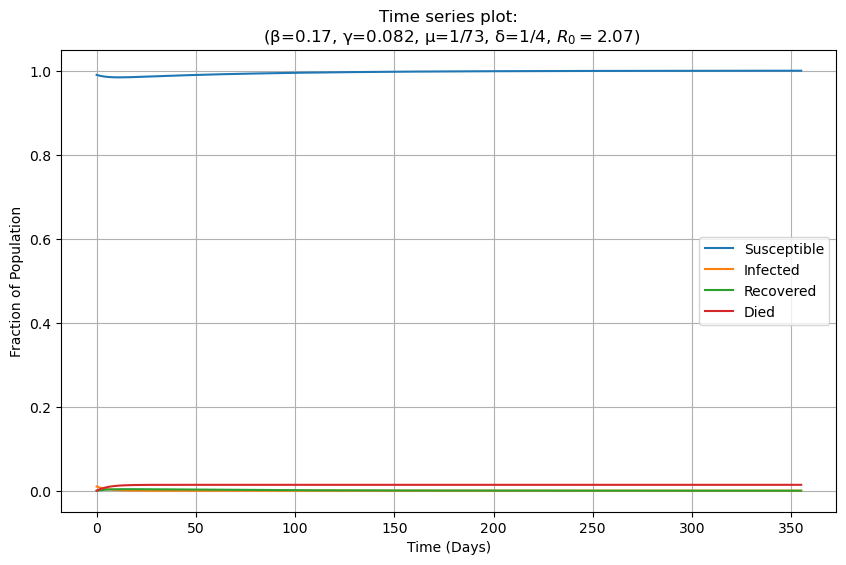

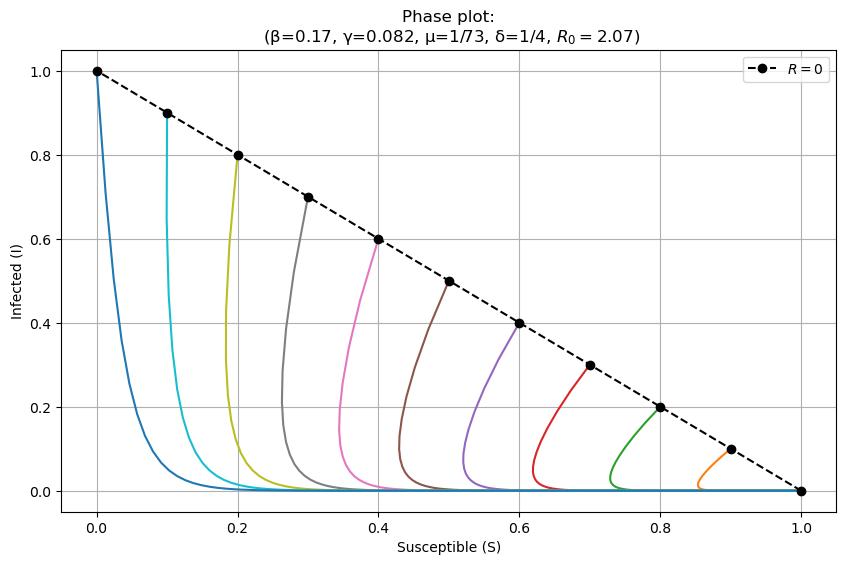

In [75]:
parameters = (0.17, 0.082, Fraction(1, 73), Fraction(1, 4))
y0 = {"S": 0.99, "I": 0.01, "R": 0, "D": 0}

sird_demographic_model = SIRD_demographic(y0, parameters, t)
sird_demographic_data = sird_demographic_model.solve(sird_demographic_model.equations)

fig, ax = sird_demographic_model.time_plot(sird_demographic_data, ["Susceptible", "Infected", "Recovered", "Died"], ["Time (Days)", "Fraction of Population"])
R0 = sird_demographic_model.R0()
ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, δ={parameters[3]}, $R_0={R0}$)")
fig.show()

fig, ax = sird_demographic_model.phase_plot()
ax.set_title(f"Phase plot:\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, δ={parameters[3]}, $R_0={R0}$)")
fig.show()

/tmp/ipykernel_8702/2055442423.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


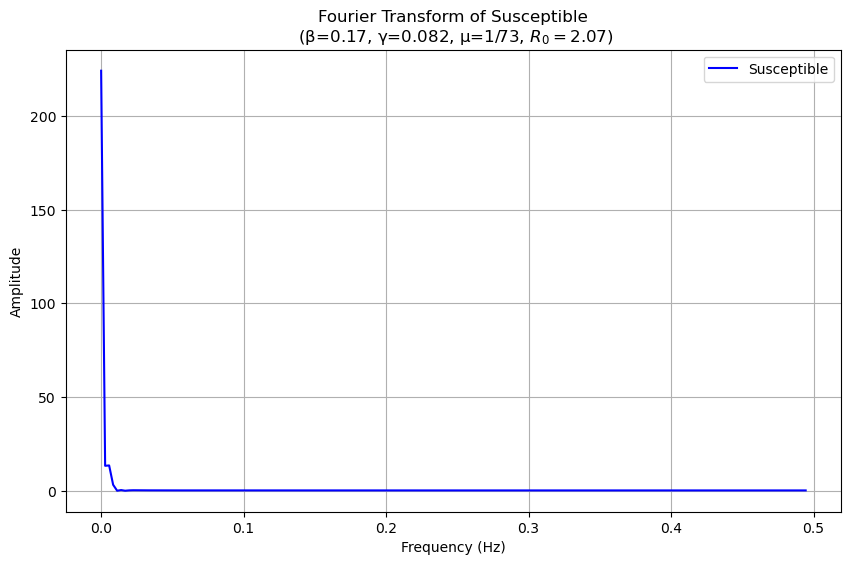

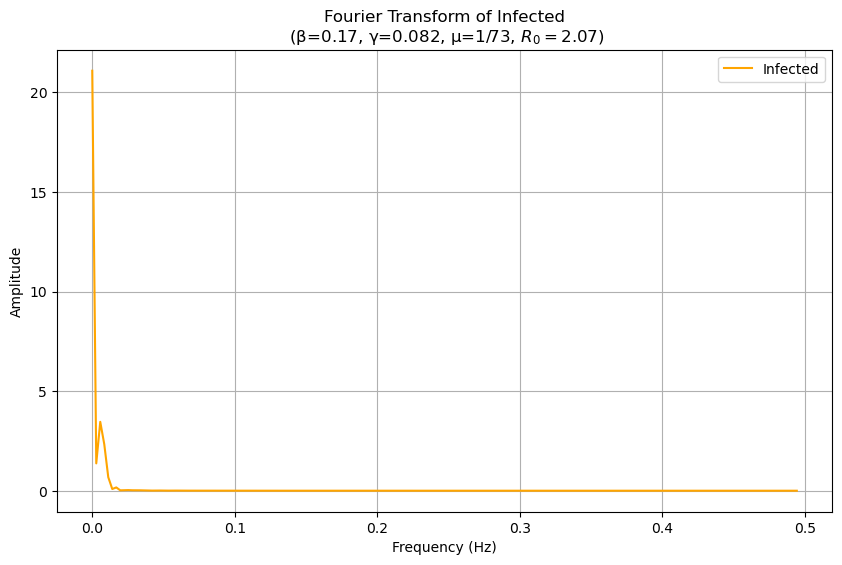

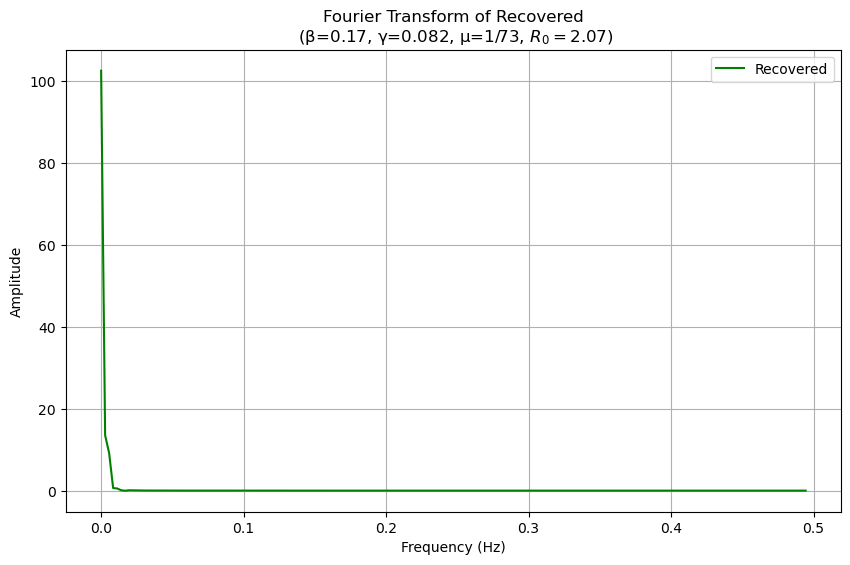

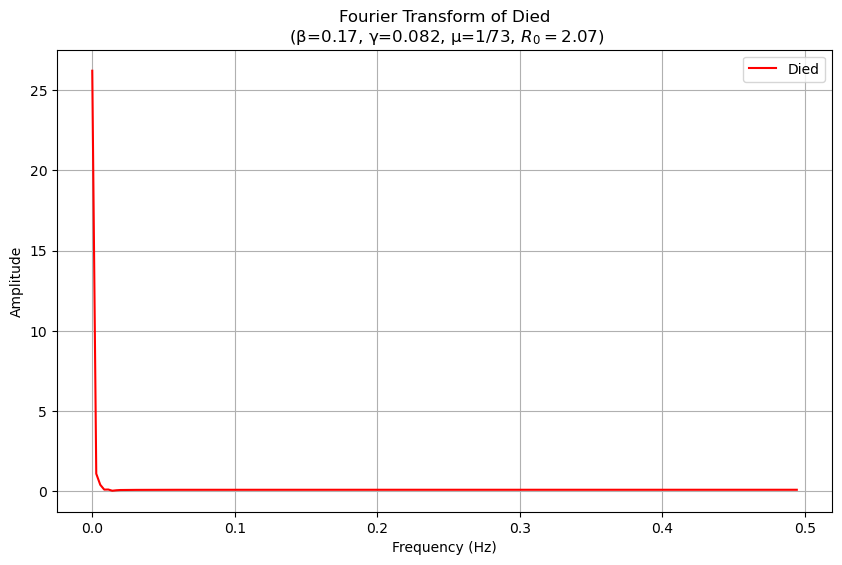

In [67]:
plot_style_dict = {
    "Susceptible": "blue",
    "Infected": "orange",
    "Recovered": "green",
    "Died": "red"
}

for compartment, plot_style in zip(sird_demographic_data, plot_style_dict):
    fig, ax = sir_demographic_model.fourier_plot(compartment, plot_style, plot_style_dict[plot_style])
    R0 = sir_demographic_model.R0()
    ax.set_title(f"Fourier Transform of {plot_style}\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, $R_0={R0}$)")

    fig.show()

--------------
# Problem 3: Variants of the SIR model
## 3.1 Numerically solve a variant of the SIR model and analyse the behaviour of the model under different parameter conditions.

In [76]:
class SEIR(EpidemiologyModel):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        super().__init__(initial_conditions, parameters, t, steps)

    def equations(self, t, init_y, beta, gamma, mu, alpha):
        S, I, R, E = init_y
        dSdt = mu - beta * S * I - mu * S
        dEdt = beta * S * I - (mu + alpha) * E
        dIdt = alpha * E- (mu + gamma) * I
        dRdt = gamma * I - mu * R
        return [dSdt, dIdt, dRdt, dEdt]

    def R0(self):
        beta, gamma, mu, alpha = self.parameters
        R0 = (alpha / (mu + alpha)) * (beta / (mu + gamma)) if gamma != 0 and alpha != 0 else 0
        return round(float(R0), 2)

In [77]:
def quater_labels(ax, YEARS):
    DAYS = 365
    QUARTER = 4
    quarters = np.arange(0, YEARS * QUARTER + 1)
    quarter_labels = [f"Q{q % QUARTER + 1}\nY{q // QUARTER + 1}" if q % QUARTER == 0 else f"Q{q % QUARTER + 1}" for q in quarters]
    ax.set_xticks(quarters * DAYS / QUARTER)
    ax.set_xticklabels(quarter_labels)

\begin{align}
\frac{dS}{dt} &= \mu - \beta S I - \mu S, \\
\frac{dE}{dt} &= \beta S I - (\mu + \alpha) E, \\
\frac{dI}{dt} &= \alpha E - (\mu + \gamma) I, \\
\frac{dt}{dt} &= \gamma I - \mu R.
\end{align}
Whereby $\mu =$ birth and deathrate and $\alpha = $ latency period

/tmp/ipykernel_8702/1709877706.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/1835631318.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/1709877706.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


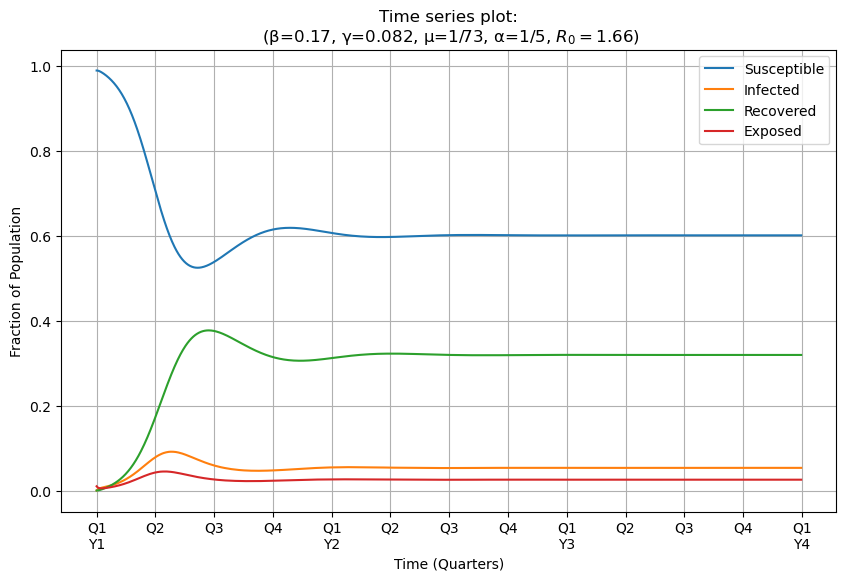

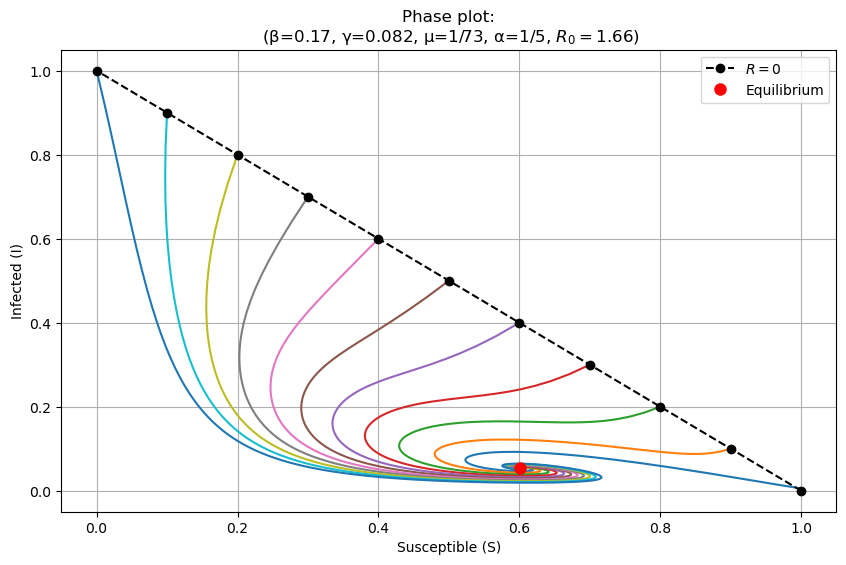

In [81]:
YEARS = 3
DAYS = 365
t = DAYS * YEARS

# parameters = (Fraction(2, 1), Fraction(1,10), Fraction(1, 100), Fraction(1, 5))
parameters = (0.17, 0.082, Fraction(1, 73), Fraction(1,5))
y0 = {"S": 0.99, "I": 0.0, "R": 0, "E": 0.01}

seir_model = SEIR(y0, parameters, t)
seir_data = seir_model.solve(seir_model.equations)

fig, ax = seir_model.time_plot(seir_data, ["Susceptible", "Infected", "Recovered", "Exposed"], ["Time (Quarters)", "Fraction of Population"])
R0 = seir_model.R0()
ax.set_title(f"Time series plot:\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, α={parameters[3]}, $R_0={float(R0)}$)")
quater_labels(ax, YEARS)
fig.show()

fig, ax = seir_model.phase_plot(show_equilibrium=True)
ax.set_title(f"Phase plot:\n (β={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, α={parameters[3]}, $R_0={R0}$)")
fig.show()

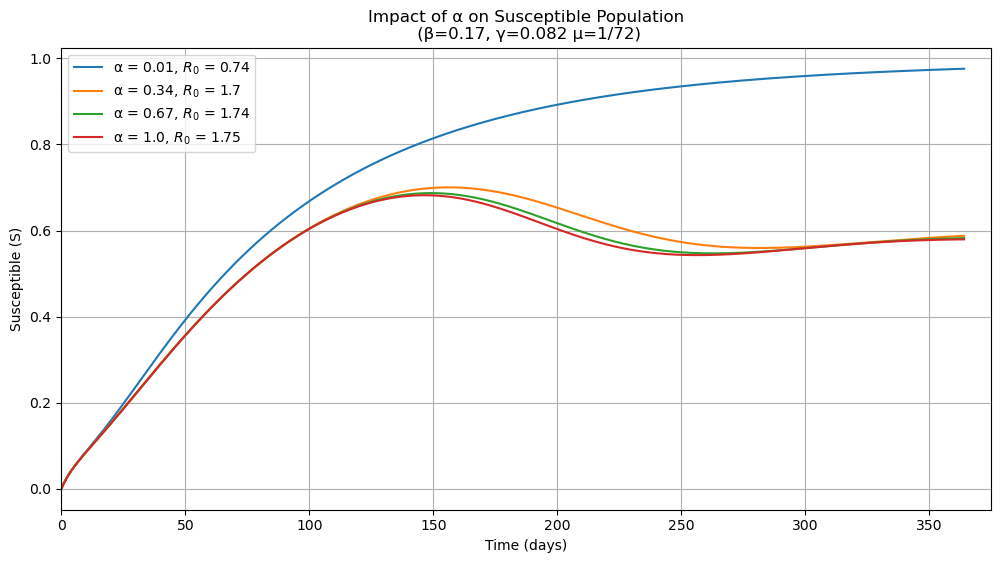

In [103]:
beta, gamma, mu = 0.17, 0.082, Fraction(1, 72)
alpha_values = np.round(np.linspace(0.01, 1, 4), 2)
fig, ax = plt.subplots(figsize=(12, 6))
t = DAYS

for alpha in alpha_values:
    parameters = (beta, gamma, mu, alpha)
    seir_model = SEIR(y0, parameters, t)
    seir_data = seir_model.solve(seir_model.equations)

    S, I, R, E = seir_data
    ax.plot(S, label=f'α = {alpha}, $R_0$ = {seir_model.R0()}')

ax.set_xlabel("Time (days)")
ax.set_xlim(0, t + 10)
ax.set_ylabel("Susceptible (S)")
# ax.set_ylim(0, 0.2)
ax.set_title(f"Impact of α on Susceptible Population\n (β={beta}, γ={gamma} μ={mu})")
ax.legend()
ax.grid()

plt.show()

## 3.2 Seasonal effects on the SEIR model

In [104]:
class SEIR_season(EpidemiologyModel):
    def __init__(self, initial_conditions, parameters, t, steps=None):
        super().__init__(initial_conditions, parameters, t, steps)

    def equations(self, t, init_y, beta_0, gamma, mu, alpha, beta_1, omega):
        S, I, R, E = init_y
        beta_t = beta_0 * (1 + beta_1 * np.cos(omega * t))
        dSdt = mu - beta_t * S * I - mu * S
        dEdt = beta_t * S * I - (mu + alpha) * E
        dIdt = alpha * E- (mu + gamma) * I
        dRdt = gamma * I - mu * R
        return [dSdt, dIdt, dRdt, dEdt]

    def R0(self):
        beta, gamma, mu, alpha, _, _ = self.parameters
        R0 = (alpha / (mu + alpha)) * (beta / (mu + gamma)) if gamma != 0 and alpha != 0 else 0
        return round(float(R0), 2)

/tmp/ipykernel_8702/3043581994.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8702/3994492601.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(init_condition_S, init_condition_I, 'k--', color='black', marker='o', label='$R=0$')
/tmp/ipykernel_8702/3043581994.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


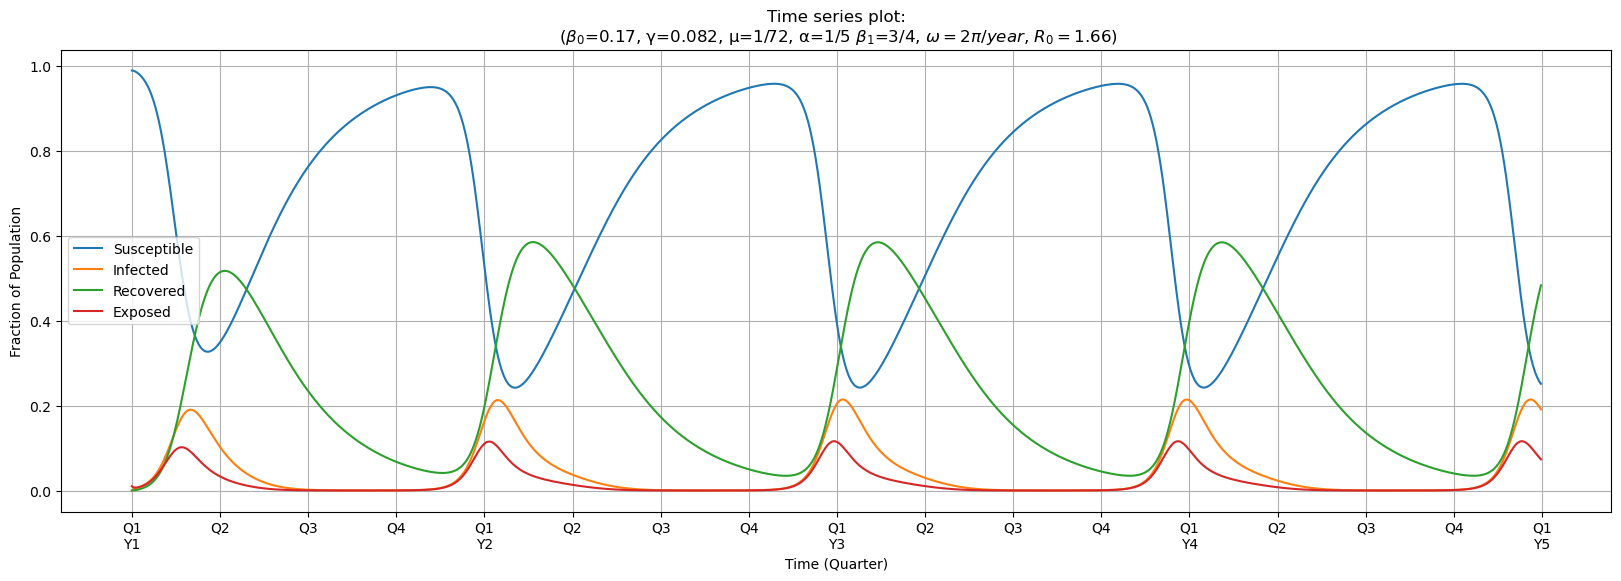

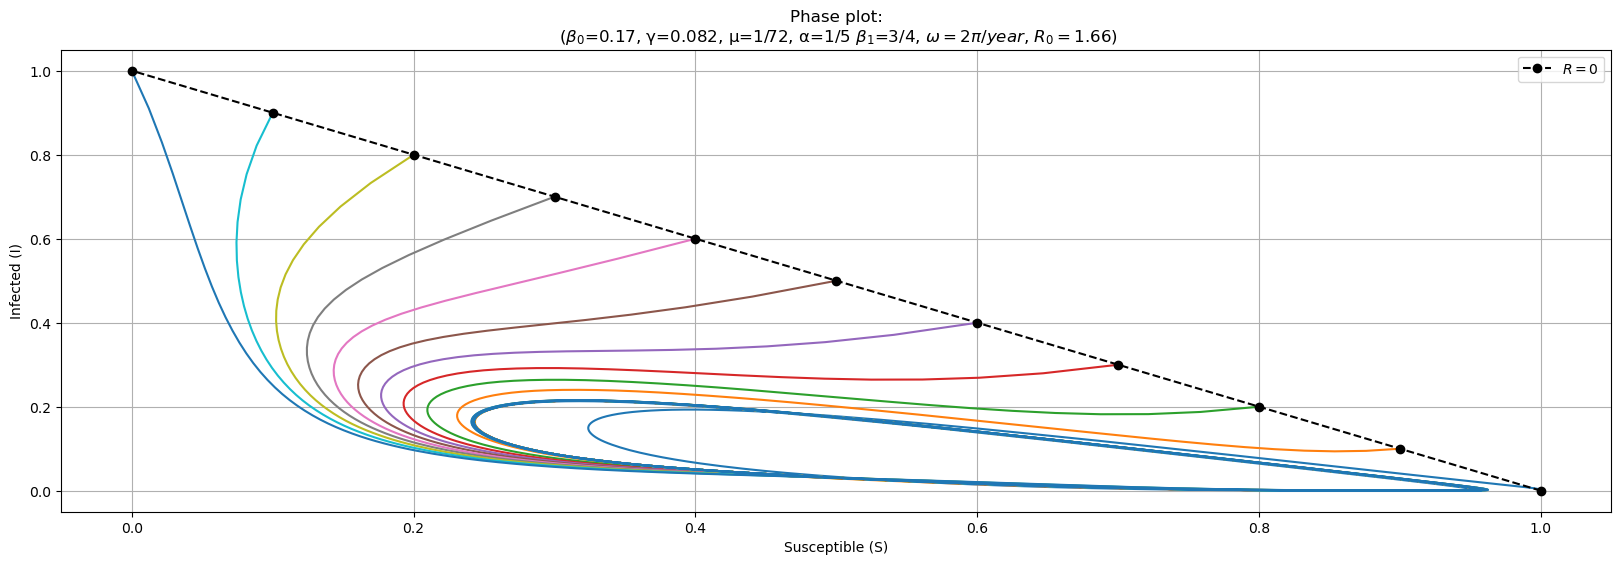

In [106]:
YEARS = 4
DAYS = 365
t = DAYS * YEARS

# beta_0, gamma, mu, alpha, beta_1, omega
parameters = (0.17, 0.082, Fraction(1, 72), Fraction(1, 5), Fraction(3, 4), 2 * np.pi / 356)
y0 = {"S": 0.99, "I": 0.0, "R": 0, "E": 0.01}

seir_model = SEIR_season(y0, parameters, t)
seir_data = seir_model.solve(seir_model.equations)

fig, ax = seir_model.time_plot(seir_data, ["Susceptible", "Infected", "Recovered", "Exposed"], ["Time (Quarter)", "Fraction of Population"])
R0 = seir_model.R0()
ax.set_title(f"Time series plot:\n ($β_0$={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, α={parameters[3]} $β_1$={parameters[4]}, $ω=2π/year$, $R_0={float(R0)}$)")
quater_labels(ax, YEARS)
fig.show()

fig, ax = seir_model.phase_plot()
ax.set_title(f"Phase plot:\n ($β_0$={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, α={parameters[3]} $β_1$={parameters[4]}, $ω=2π/year$, $R_0={float(R0)}$)")
fig.show()

/tmp/ipykernel_8702/3401729266.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


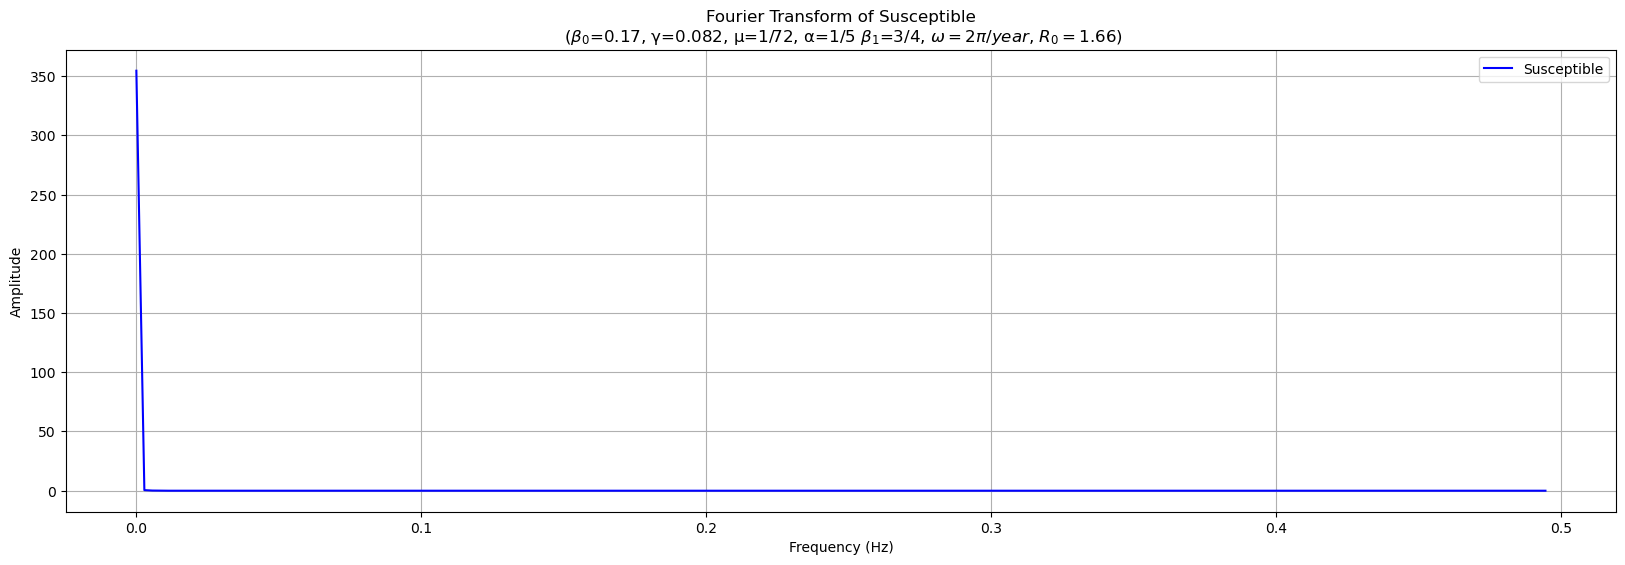

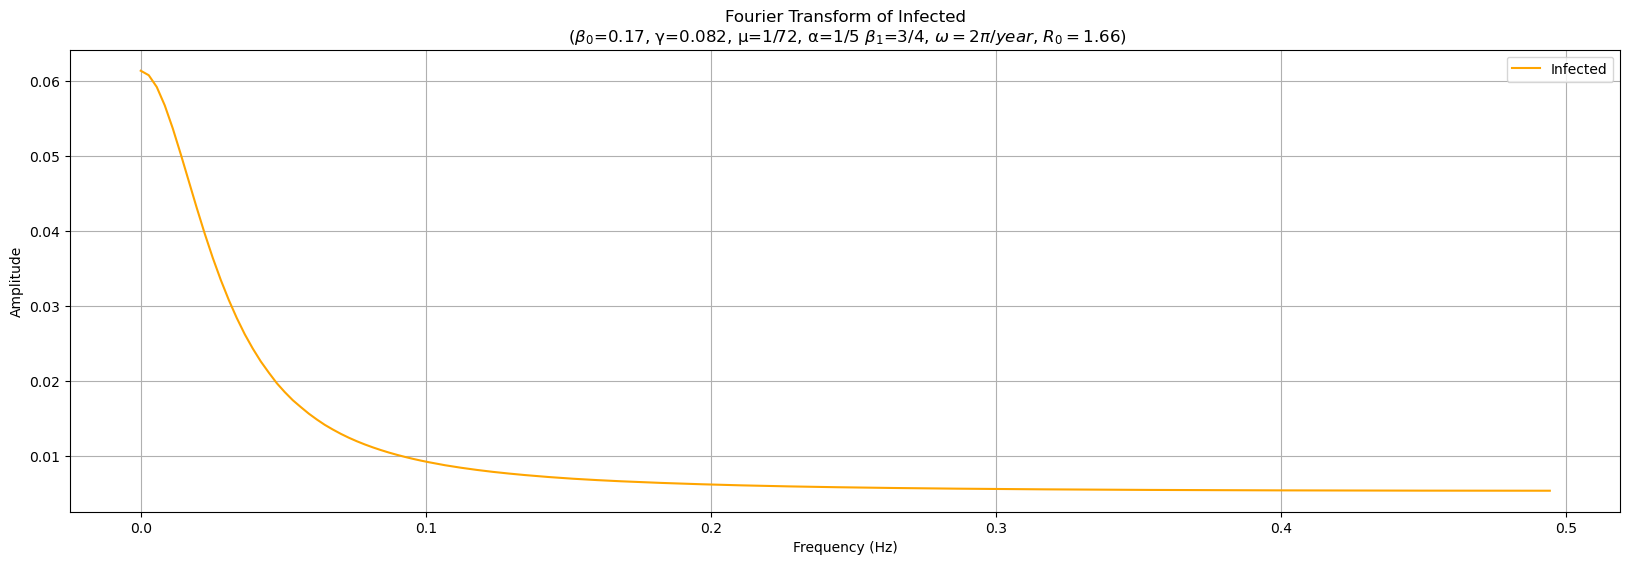

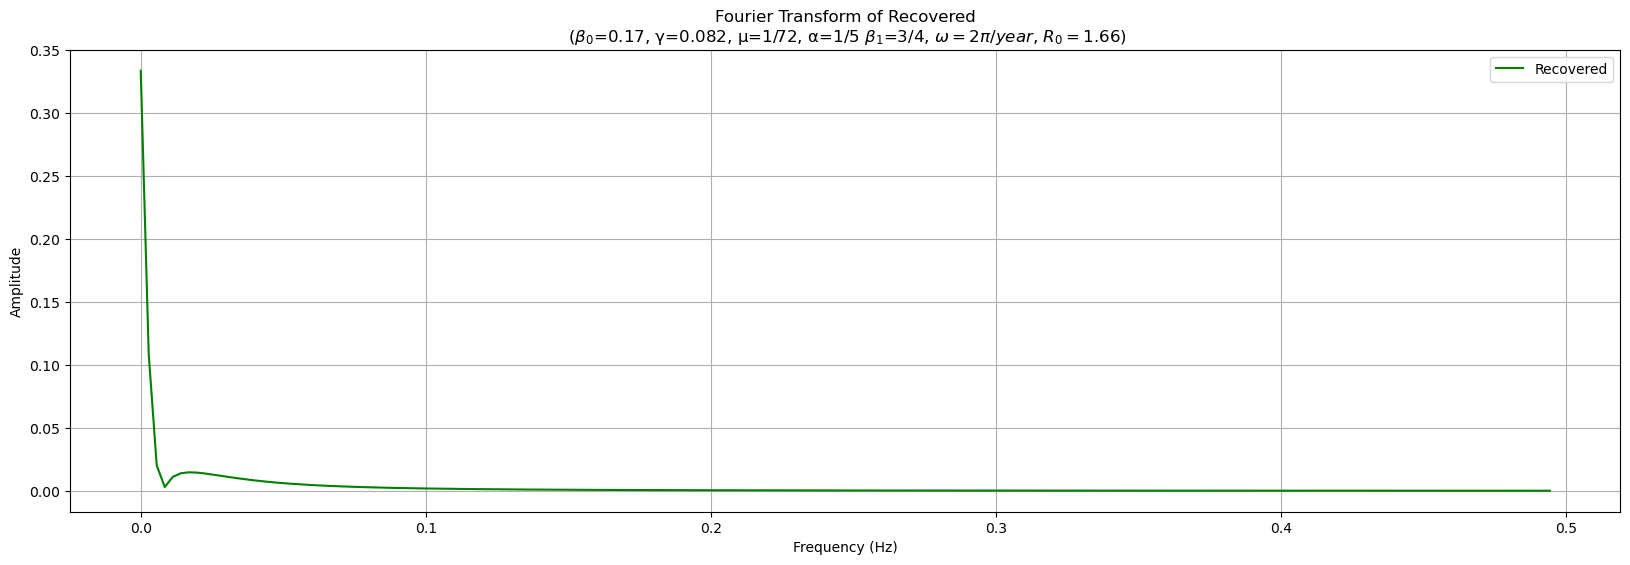

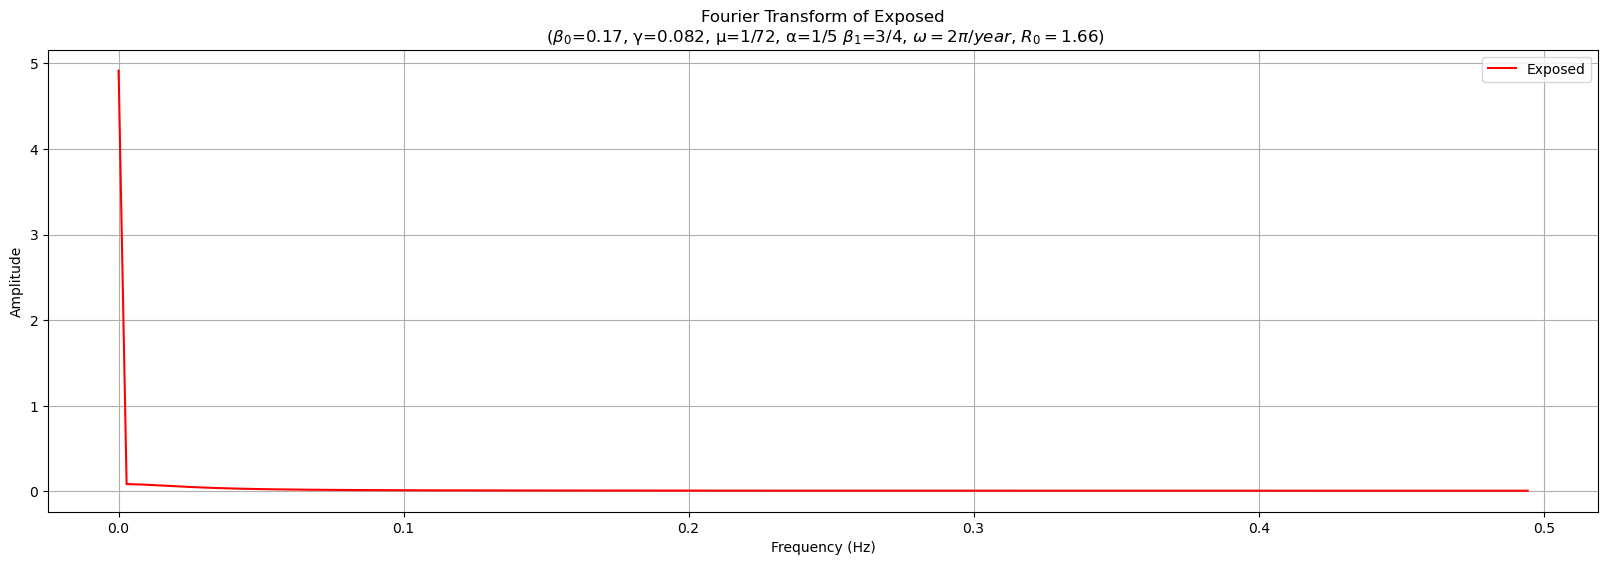

In [108]:
plot_style_dict = {
    "Susceptible": "blue",
    "Infected": "orange",
    "Recovered": "green",
    "Exposed": "red"
}

for compartment, plot_style in zip(sird_demographic_data, plot_style_dict):
    fig, ax = seir_model.fourier_plot(compartment, plot_style, plot_style_dict[plot_style])
    R0 = seir_model.R0()
    ax.set_title(f"Fourier Transform of {plot_style}\n ($β_0$={parameters[0]}, γ={parameters[1]}, μ={parameters[2]}, α={parameters[3]} $β_1$={parameters[4]}, $ω=2π/year$, $R_0={float(R0)}$)")


    fig.show()